In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from tqdm import tqdm
import numpy as np

In [2]:
def get_aupr(pre, rec):
    pr_value = 0.0
    for ii in range(len(rec[:-1])):
        x_r, x_l = rec[ii], rec[ii+1]
        y_t, y_b = pre[ii], pre[ii+1]
        tempo = abs(x_r - x_l) * (y_t + y_b) * 0.5
        pr_value += tempo
    return pr_value

from sklearn.metrics import confusion_matrix

def scores_regression(y_true, y_pred):
    # Round predictions to nearest class (0–4)
    y_pred_class = np.clip(np.round(y_pred).astype(int), 0, 4)

    # Core regression metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_class, labels=[0, 1, 2, 3, 4])

    return [mse, rmse, mae, r2], cm



In [3]:
def combine_features(phage_dna, host_dna, phage_pro, host_pro):
    combined = np.concatenate([phage_dna, host_dna, phage_pro, host_pro], axis=1)
    return combined


def load_feature_vector(file_path):
    return np.loadtxt(file_path)


def obtain_features(phage_list, host_list, labels, dna_base, pro_base):
    X_phage_dna, X_host_dna = [], []
    X_phage_pro, X_host_pro = [], []
    for p, h in zip(phage_list, host_list):
        X_phage_dna.append(load_feature_vector(os.path.join(dna_base, 'phage', f'{p}.txt')))
        X_host_dna.append(load_feature_vector(os.path.join(dna_base, 'bacteria', f'{h}.txt')))
        X_phage_pro.append(load_feature_vector(os.path.join(pro_base, 'phage', f'{p}.txt')))
        X_host_pro.append(load_feature_vector(os.path.join(pro_base, 'bacteria', f'{h}.txt')))
    return (np.array(X_phage_dna), np.array(X_host_dna),
            np.array(X_phage_pro), np.array(X_host_pro),
            np.array(labels))


In [4]:
interaction_matrix_path = "./ordinal_dataset_features/ordinal_interaction_matrix.csv"

dna_base = './ordinal_dataset_features/dna_features_ordinal_data'
pro_base = './ordinal_dataset_features/prot_features_ordinal_data'

In [5]:
df = pd.read_csv(interaction_matrix_path, index_col=0, sep=";")

valid_phages = set([f.split('.')[0] for f in os.listdir(dna_base + "/phage") if f.endswith('.txt')])
valid_hosts = set([f.split('.')[0] for f in os.listdir(pro_base + "/bacteria") if f.endswith('.txt')])

#filter unused interaction since matrix to large
df = df.loc[df.index.intersection(valid_hosts), df.columns.intersection(valid_phages)]

phages = df.columns.tolist()
hosts = df.index.tolist()
print(len(phages))
print(len(hosts))
# Prepare data as list of (phage, host, label)

96
402


In [6]:
all_data = []

for p in phages:
    for h in hosts:
        label = df.loc[h, p]
        if pd.isna(label):
            continue  # Skip missing values
        all_data.append([p, h, label])

In [11]:

labels = np.asarray([row[2] for row in all_data])
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
stratify_labels = binner.fit_transform(labels.reshape(-1, 1)).astype(int).ravel()

kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

X_full = []
y_full = []
for row in all_data:
    X_full.append(combine_features(*obtain_features([row[0]], [row[1]], [row[2]], dna_base, pro_base)[:-1]))
    y_full.append(row[2])
X_full = np.vstack(X_full)
y_full = np.array(y_full)

param_grid = {
    'n_estimators': [150],#100
    'max_depth': [ 10],#10,
    'learning_rate': [ 0.1],#0.05,
}

reg_base = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
grid_search = GridSearchCV(reg_base, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_full, y_full)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}


In [12]:

# Cross-validation with tuned model
results_all = []
models = []
conf_matrices = []
pbar = tqdm(total=kf.get_n_splits(all_data, stratify_labels))

for fold, (train_idx, val_idx) in enumerate(kf.split(all_data, stratify_labels)):
    print(f"Fold {fold + 1}")

    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(
        train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(
        val_phages, val_hosts, val_labels, dna_base, pro_base)

    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val)

    best_model = XGBRegressor(**best_params, objective='reg:squarederror', n_jobs=-1, random_state=42)
    best_model.fit(X_train_combined, y_train)
    models.append(best_model)

    y_pred = best_model.predict(X_val_combined)

    try:
         fold_scores, cm = scores_regression(y_val, y_pred) 
    except Exception as e:
        print(f"Error on fold: {e}")
        fold_scores = [np.nan] * 3

    results_all.append(fold_scores)
    conf_matrices.append(cm)
    pbar.update(1)

pbar.close()



 60%|██████    | 3/5 [3:20:08<2:13:25, 4002.73s/it]


Fold 1



 20%|██        | 1/5 [01:04<04:17, 64.27s/it]

Fold 2



 40%|████      | 2/5 [02:07<03:11, 63.92s/it]

Fold 3



 60%|██████    | 3/5 [03:12<02:08, 64.06s/it]

Fold 4



 80%|████████  | 4/5 [04:15<01:03, 63.73s/it]

Fold 5



100%|██████████| 5/5 [05:19<00:00, 63.96s/it]


In [13]:
metric_names = ["MSE", "RMSE", "MAE", "R2"]

results_array = np.array(results_all)
results_df = pd.DataFrame(results_array, columns=metric_names)
results_df.index = [f"Fold {i + 1}" for i in range(len(results_all))]

# Print fold-wise results
print("=== Fold-wise Performance ===")
display(results_df)

# Summary stats
print("\n=== Mean ===")
display(results_df.mean())

print("\n=== Std Dev ===")
display(results_df.std())

=== Fold-wise Performance ===


,MSE,RMSE,MAE,R2
Fold 1,0.440289,0.663543,0.359213,0.551317
Fold 2,0.423097,0.650459,0.355995,0.568837
Fold 3,0.432297,0.657493,0.361015,0.559942
Fold 4,0.422285,0.649835,0.359616,0.570013
Fold 5,0.441129,0.664175,0.370277,0.551204



=== Mean ===


MSE     0.431820
RMSE    0.657101
MAE     0.361223
R2      0.560263
dtype: float64


=== Std Dev ===


MSE     0.009022
RMSE    0.006867
MAE     0.005385
R2      0.009093
dtype: float64

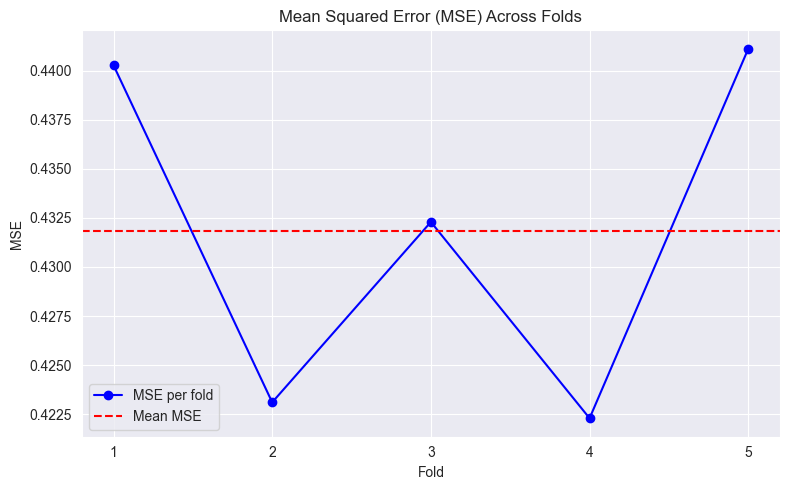

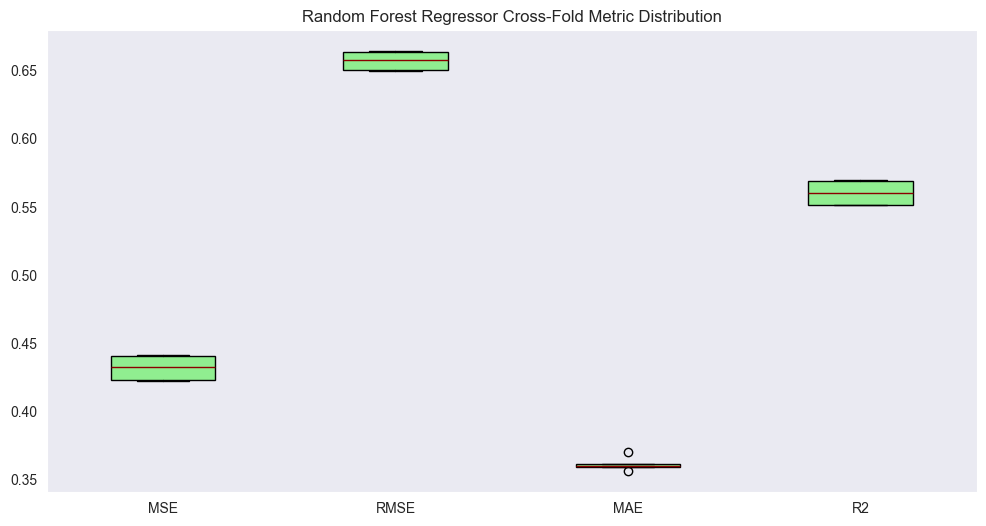

In [14]:
import matplotlib.pyplot as plt

# Assuming results_array[:, 0] contains MSE values per fold
mse_values = results_array[:, 0]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE per fold')
plt.axhline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
plt.title('Mean Squared Error (MSE) Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.xticks(range(1, len(mse_values) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.boxplot(results_array, tick_labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='darkred'),
            whiskerprops=dict(color='black'))
plt.title("Random Forest Regressor Cross-Fold Metric Distribution")
plt.grid()
plt.show()

[[26704  3288   437    28     2]
 [ 1017  1563   385    48     1]
 [  377  1029   758   136     6]
 [  106   400   521   322    19]
 [   62   235   388   430   173]]


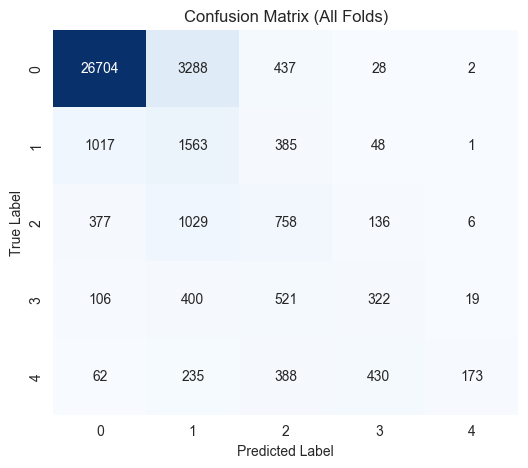

In [15]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Sum all confusion matrices
avg_cm = np.sum(conf_matrices, axis=0)
print(avg_cm)

# Step 2: Plot the averaged confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (All Folds)")
plt.show()

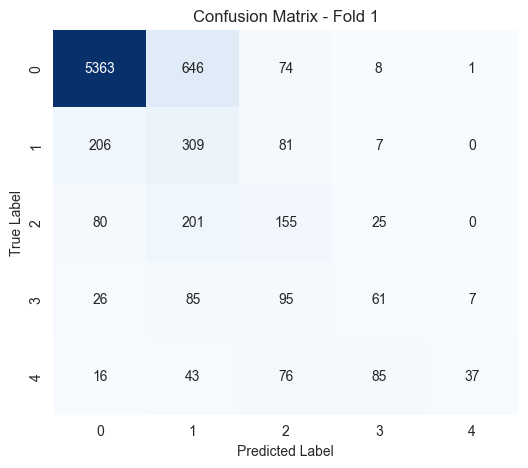

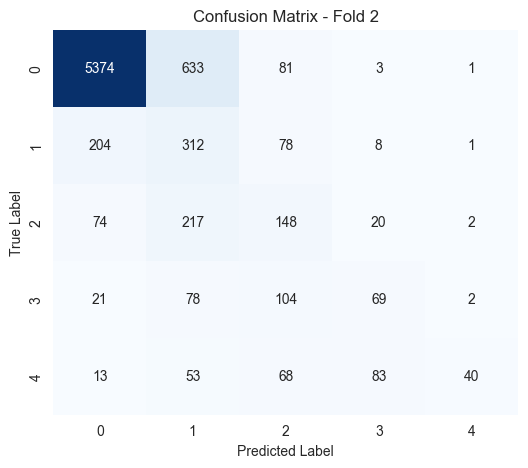

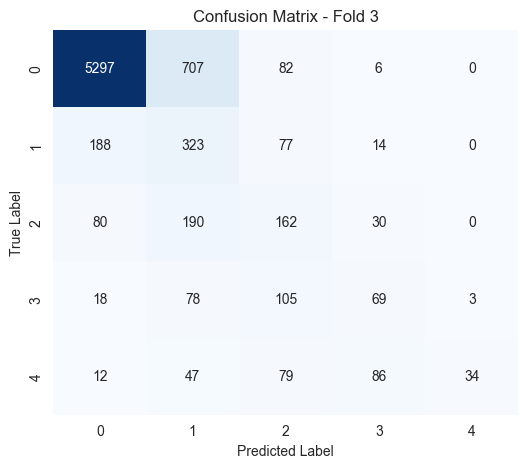

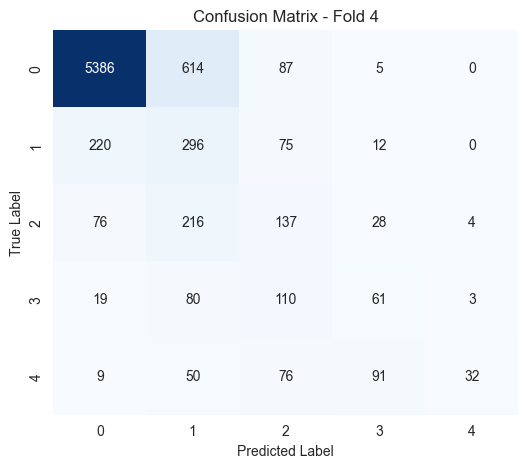

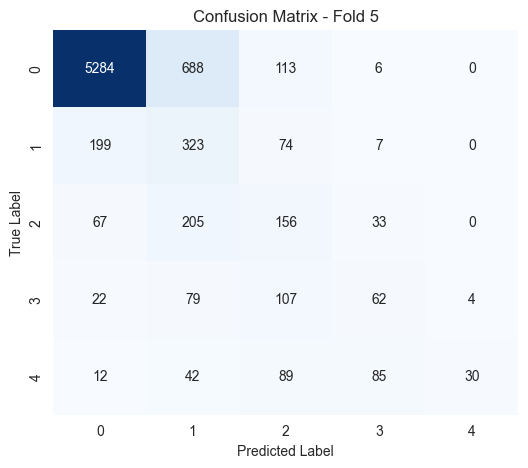

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt

for i, cm in enumerate(conf_matrices):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {i + 1}")
    plt.show()
    

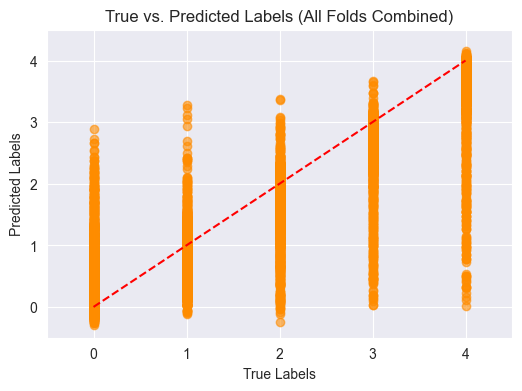

In [17]:
all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(X_full, labels):
    X_test = X_full[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Convert to NumPy arrays for plotting
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Plotting combined true vs. predicted labels
plt.figure(figsize=(6, 4))
plt.scatter(all_y_true, all_y_pred, alpha=0.6, color='darkorange')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("True vs. Predicted Labels (All Folds Combined)")
plt.plot([0, 4], [0, 4], 'r--')  # identity line
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, 4.5)
plt.grid(True)
plt.show()

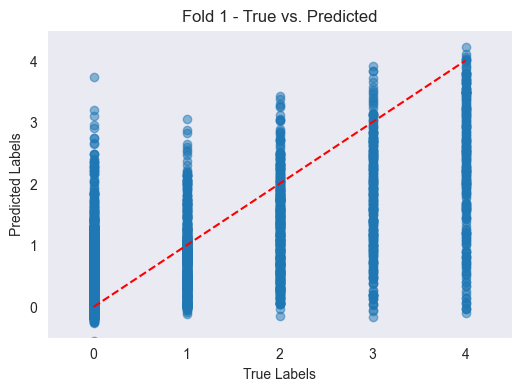

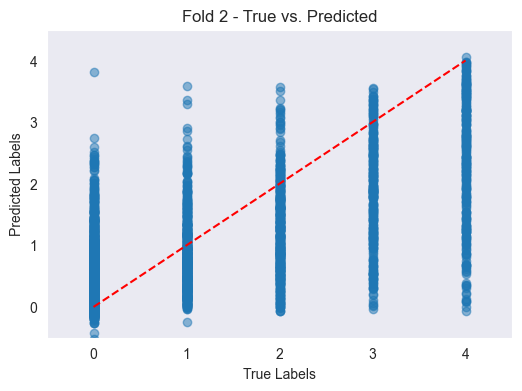

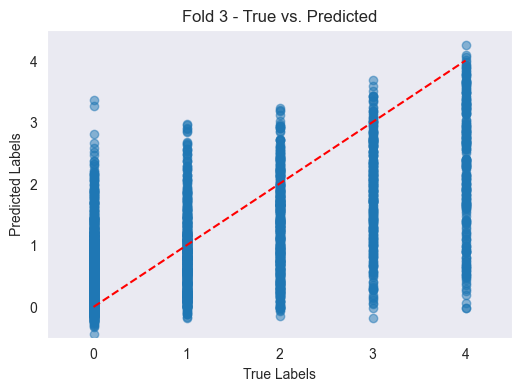

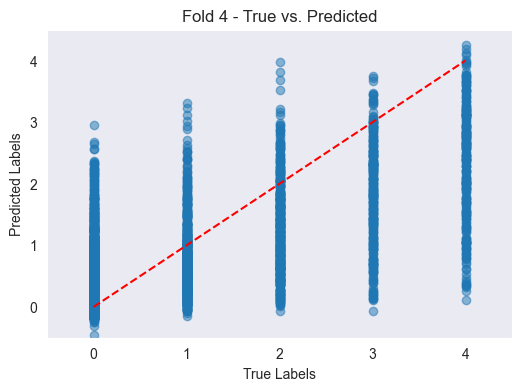

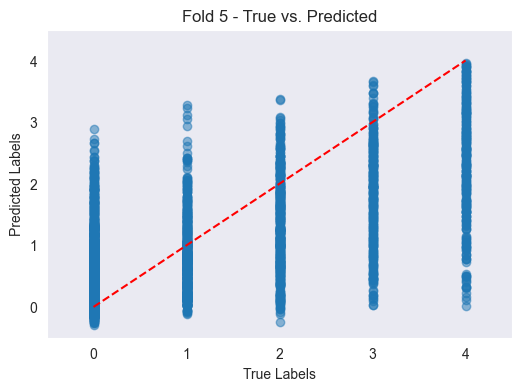

In [18]:
for i, (train_idx, test_idx) in enumerate(kf.split(X_full, labels)):
    X_test = X_full[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"Fold {i + 1} - True vs. Predicted")
    plt.grid()
    plt.plot([0, 4], [0, 4], 'r--')
    plt.xlim(-0.5, 4.5)
    plt.ylim(-0.5, 4.5)
    plt.show()


In [ ]:
labels = np.asarray([row[2] for row in all_data])

binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
stratify_labels = binner.fit_transform(labels.reshape(-1, 1)).astype(int).ravel()

features_full = []
for row in all_data:
    phage, host, label = row
    X_phage_dna, X_host_dna, X_phage_pro, X_host_pro, _ = obtain_features(
        [phage], [host], [label], dna_base, pro_base)
    combined = combine_features(X_phage_dna, X_host_dna, X_phage_pro, X_host_pro)
    features_full.append(combined)

features_full = np.vstack(features_full)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [200,250],
    'max_depth': [15, 20],
    'min_samples_leaf': [8, 10],
}

rf_base = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    rf_base,
    param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(features_full, labels)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_all = []
models = []
conf_matrices = []

pbar = tqdm(total=kf.get_n_splits(all_data, stratify_labels))

for fold, (train_idx, val_idx) in enumerate(kf.split(all_data, stratify_labels)):
    print(f"Fold {fold + 1}")

    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(
        train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(
        val_phages, val_hosts, val_labels, dna_base, pro_base)

    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val)

    # Train Random Forest with best params
    model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
    model.fit(X_train_combined, y_train)
    models.append(model)

    y_pred = model.predict(X_val_combined)

    try:
        fold_scores,cm = scores_regression(y_val, y_pred)  # e.g., [RMSE, MAE, R2]
    except Exception as e:
        print(f"Error in fold {fold+1}: {e}")
        fold_scores = [np.nan] * 3

    print(f"Fold {fold+1} | RMSE: {fold_scores[0]:.4f}, MAE: {fold_scores[1]:.4f}, R2: {fold_scores[2]:.4f}")
    results_all.append(fold_scores)
    conf_matrices.append(cm)
    pbar.update(1)

pbar.close()


In [ ]:
metric_names = ["MSE", "RMSE", "MAE", "R2"]

results_array = np.array(results_all)
results_df = pd.DataFrame(results_array, columns=metric_names)
results_df.index = [f"Fold {i + 1}" for i in range(len(results_all))]

# Print fold-wise results
print("=== Fold-wise Performance ===")
display(results_df)

# Summary stats
print("\n=== Mean ===")
display(results_df.mean())

print("\n=== Std Dev ===")
display(results_df.std())

In [ ]:

import matplotlib.pyplot as plt

# Assuming results_array[:, 0] contains MSE values per fold
mse_values = results_array[:, 0]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE per fold')
plt.axhline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
plt.title('Mean Squared Error (MSE) Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.xticks(range(1, len(mse_values) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.boxplot(results_array, tick_labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='darkred'),
            whiskerprops=dict(color='black'))
plt.title("Random Forest Regressor Cross-Fold Metric Distribution")
plt.grid()
plt.show()

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Sum all confusion matrices
avg_cm = np.sum(conf_matrices, axis=0)
print(avg_cm)

# Step 2: Plot the averaged confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (All Folds)")
plt.show()

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

for i, cm in enumerate(conf_matrices):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {i + 1}")
    plt.show()

In [ ]:

all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(features_full, labels):
    X_test = features_full[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Convert to NumPy arrays for plotting
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Plotting combined true vs. predicted labels
plt.figure(figsize=(6, 4))
plt.scatter(all_y_true, all_y_pred, alpha=0.6, color='darkorange')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("True vs. Predicted Labels (All Folds Combined)")
plt.plot([0, 4], [0, 4], 'r--')  # identity line
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, 4.5)
plt.grid(True)
plt.show()

In [ ]:

for i, (train_idx, test_idx) in enumerate(kf.split(features_full, labels)):
    X_test = features_full[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"Fold {i + 1} - True vs. Predicted")
    plt.grid()
    plt.plot([0, 4], [0, 4], 'r--')
    plt.xlim(-0.5, 4.5)
    plt.ylim(-0.5, 4.5)
    plt.show()
